## Init libs

In [1]:
import matplotlib
import time
import matplotlib.pyplot as plt

In [2]:
from functools import partial
from itertools import repeat
from torch._six import container_abcs

import logging
import os
from collections import OrderedDict

import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import DropPath, trunc_normal_

from models.registry import register_model
from models import build_model

## Init cls_cvt

In [3]:
num_class = 10
dim_image = 32

In [4]:
# From PyTorch internals
def _ntuple(n):
    def parse(x):
        if isinstance(x, container_abcs.Iterable):
            return x
        return tuple(repeat(x, n))

    return parse


to_1tuple = _ntuple(1)
to_2tuple = _ntuple(2)
to_3tuple = _ntuple(3)
to_4tuple = _ntuple(4)
to_ntuple = _ntuple

In [5]:
class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)

In [6]:
class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)

In [7]:
class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [8]:
class Attention(nn.Module):
    def __init__(
        self,
        dim_in,
        dim_out,
        num_heads,
        qkv_bias=False,
        attn_drop=0.0,
        proj_drop=0.0,
        method="dw_bn",
        kernel_size=3,
        stride_kv=1,
        stride_q=1,
        padding_kv=1,
        padding_q=1,
        with_cls_token=True,
        **kwargs
    ):
        super().__init__()
        self.stride_kv = stride_kv
        self.stride_q = stride_q
        self.dim = dim_out
        self.num_heads = num_heads
        # head_dim = self.qkv_dim // num_heads
        self.scale = dim_out**-0.5
        self.with_cls_token = with_cls_token

        self.conv_proj_q = self._build_projection(
            dim_in,
            dim_out,
            kernel_size,
            padding_q,
            stride_q,
            "linear" if method == "avg" else method,
        )
        self.conv_proj_k = self._build_projection(
            dim_in, dim_out, kernel_size, padding_kv, stride_kv, method
        )
        self.conv_proj_v = self._build_projection(
            dim_in, dim_out, kernel_size, padding_kv, stride_kv, method
        )

        self.proj_q = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.proj_k = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.proj_v = nn.Linear(dim_in, dim_out, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim_out, dim_out)
        self.proj_drop = nn.Dropout(proj_drop)

    def _build_projection(self, dim_in, dim_out, kernel_size, padding, stride, method):
        if method == "dw_bn":
            proj = nn.Sequential(
                OrderedDict(
                    [
                        (
                            "conv",
                            nn.Conv2d(
                                dim_in,
                                dim_in,
                                kernel_size=kernel_size,
                                padding=padding,
                                stride=stride,
                                bias=False,
                                groups=dim_in,
                            ),
                        ),
                        ("bn", nn.BatchNorm2d(dim_in)),
                        ("rearrage", Rearrange("b c h w -> b (h w) c")),
                    ]
                )
            )
        elif method == "avg":
            proj = nn.Sequential(
                OrderedDict(
                    [
                        (
                            "avg",
                            nn.AvgPool2d(
                                kernel_size=kernel_size,
                                padding=padding,
                                stride=stride,
                                ceil_mode=True,
                            ),
                        ),
                        ("rearrage", Rearrange("b c h w -> b (h w) c")),
                    ]
                )
            )
        elif method == "linear":
            proj = None
        else:
            raise ValueError("Unknown method ({})".format(method))

        return proj

    def forward_conv(self, x, h, w):
        if self.with_cls_token:
            cls_token, x = torch.split(x, [1, h * w], 1)

        x = rearrange(x, "b (h w) c -> b c h w", h=h, w=w)

        if self.conv_proj_q is not None:
            q = self.conv_proj_q(x)
        else:
            q = rearrange(x, "b c h w -> b (h w) c")

        if self.conv_proj_k is not None:
            k = self.conv_proj_k(x)
        else:
            k = rearrange(x, "b c h w -> b (h w) c")

        if self.conv_proj_v is not None:
            v = self.conv_proj_v(x)
        else:
            v = rearrange(x, "b c h w -> b (h w) c")

        if self.with_cls_token:
            q = torch.cat((cls_token, q), dim=1)
            k = torch.cat((cls_token, k), dim=1)
            v = torch.cat((cls_token, v), dim=1)

        return q, k, v

    def forward(self, x, h, w):
        if (
            self.conv_proj_q is not None
            or self.conv_proj_k is not None
            or self.conv_proj_v is not None
        ):
            q, k, v = self.forward_conv(x, h, w)

        q = rearrange(self.proj_q(q), "b t (h d) -> b h t d", h=self.num_heads)
        k = rearrange(self.proj_k(k), "b t (h d) -> b h t d", h=self.num_heads)
        v = rearrange(self.proj_v(v), "b t (h d) -> b h t d", h=self.num_heads)

        attn_score = torch.einsum("bhlk,bhtk->bhlt", [q, k]) * self.scale
        attn = F.softmax(attn_score, dim=-1)
        attn = self.attn_drop(attn)

        x = torch.einsum("bhlt,bhtv->bhlv", [attn, v])
        x = rearrange(x, "b h t d -> b t (h d)")

        x = self.proj(x)
        x = self.proj_drop(x)

        return x

    @staticmethod
    def compute_macs(module, input, output):
        # T: num_token
        # S: num_token
        input = input[0]
        flops = 0

        _, T, C = input.shape
        H = W = int(np.sqrt(T - 1)) if module.with_cls_token else int(np.sqrt(T))

        H_Q = H / module.stride_q
        W_Q = H / module.stride_q
        T_Q = H_Q * W_Q + 1 if module.with_cls_token else H_Q * W_Q

        H_KV = H / module.stride_kv
        W_KV = W / module.stride_kv
        T_KV = H_KV * W_KV + 1 if module.with_cls_token else H_KV * W_KV

        # C = module.dim
        # S = T
        # Scaled-dot-product macs
        # [B x T x C] x [B x C x T] --> [B x T x S]
        # multiplication-addition is counted as 1 because operations can be fused
        flops += T_Q * T_KV * module.dim
        # [B x T x S] x [B x S x C] --> [B x T x C]
        flops += T_Q * module.dim * T_KV

        if hasattr(module, "conv_proj_q") and hasattr(module.conv_proj_q, "conv"):
            params = sum([p.numel() for p in module.conv_proj_q.conv.parameters()])
            flops += params * H_Q * W_Q

        if hasattr(module, "conv_proj_k") and hasattr(module.conv_proj_k, "conv"):
            params = sum([p.numel() for p in module.conv_proj_k.conv.parameters()])
            flops += params * H_KV * W_KV

        if hasattr(module, "conv_proj_v") and hasattr(module.conv_proj_v, "conv"):
            params = sum([p.numel() for p in module.conv_proj_v.conv.parameters()])
            flops += params * H_KV * W_KV

        params = sum([p.numel() for p in module.proj_q.parameters()])
        flops += params * T_Q
        params = sum([p.numel() for p in module.proj_k.parameters()])
        flops += params * T_KV
        params = sum([p.numel() for p in module.proj_v.parameters()])
        flops += params * T_KV
        params = sum([p.numel() for p in module.proj.parameters()])
        flops += params * T

        module.__flops__ += flops

In [9]:
class Block(nn.Module):

    def __init__(
        self,
        dim_in,
        dim_out,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=False,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        **kwargs
    ):
        super().__init__()

        self.with_cls_token = kwargs["with_cls_token"]

        self.norm1 = norm_layer(dim_in)
        self.attn = Attention(
            dim_in, dim_out, num_heads, qkv_bias, attn_drop, drop, **kwargs
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim_out)

        dim_mlp_hidden = int(dim_out * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim_out,
            hidden_features=dim_mlp_hidden,
            act_layer=act_layer,
            drop=drop,
        )

    def forward(self, x, h, w):
        res = x

        x = self.norm1(x)
        attn = self.attn(x, h, w)
        x = res + self.drop_path(attn)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

In [10]:
class ConvEmbed(nn.Module):
    """Image to Conv Embedding"""

    def __init__(
        self,
        patch_size=7,
        in_chans=3,
        embed_dim=64,
        stride=4,
        padding=2,
        norm_layer=None,
    ):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=stride, padding=padding
        )
        self.norm = norm_layer(embed_dim) if norm_layer else None

    def forward(self, x):
        x = self.proj(x)

        B, C, H, W = x.shape
        x = rearrange(x, "b c h w -> b (h w) c")
        if self.norm:
            x = self.norm(x)
        x = rearrange(x, "b (h w) c -> b c h w", h=H, w=W)

        return x

In [11]:
class VisionTransformer(nn.Module):
    """Vision Transformer with support for patch or hybrid CNN input stage"""

    def __init__(
        self,
        patch_size=16,
        patch_stride=16,
        patch_padding=0,
        in_chans=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=False,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        init="trunc_norm",
        **kwargs
    ):
        super().__init__()
        self.num_features = self.embed_dim = (
            embed_dim  # num_features for consistency with other models
        )

        self.rearrage = None

        self.patch_embed = ConvEmbed(
            # img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            stride=patch_stride,
            padding=patch_padding,
            embed_dim=embed_dim,
            norm_layer=norm_layer,
        )

        with_cls_token = kwargs["with_cls_token"]
        if with_cls_token:
            self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        else:
            self.cls_token = None

        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, depth)
        ]  # stochastic depth decay rule

        blocks = []
        for j in range(depth):
            blocks.append(
                Block(
                    dim_in=embed_dim,
                    dim_out=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=dpr[j],
                    act_layer=act_layer,
                    norm_layer=norm_layer,
                    **kwargs
                )
            )
        self.blocks = nn.ModuleList(blocks)

        if self.cls_token is not None:
            trunc_normal_(self.cls_token, std=0.02)

        if init == "xavier":
            self.apply(self._init_weights_xavier)
        else:
            self.apply(self._init_weights_trunc_normal)

    def _init_weights_trunc_normal(self, m):
        if isinstance(m, nn.Linear):
            logging.info("=> init weight of Linear from trunc norm")
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                logging.info("=> init bias of Linear to zeros")
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def _init_weights_xavier(self, m):
        if isinstance(m, nn.Linear):
            logging.info("=> init weight of Linear from xavier uniform")
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                logging.info("=> init bias of Linear to zeros")
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.patch_embed(x)
        B, C, H, W = x.size()

        x = rearrange(x, "b c h w -> b (h w) c")

        cls_tokens = None
        if self.cls_token is not None:
            # stole cls_tokens impl from Phil Wang, thanks
            cls_tokens = self.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)

        x = self.pos_drop(x)

        for i, blk in enumerate(self.blocks):
            x = blk(x, H, W)

        if self.cls_token is not None:
            cls_tokens, x = torch.split(x, [1, H * W], 1)
        x = rearrange(x, "b (h w) c -> b c h w", h=H, w=W)

        return x, cls_tokens

In [12]:
class ConvolutionalVisionTransformer(nn.Module):
    def __init__(
        self,
        in_chans=3,
        num_classes=1000,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        init="trunc_norm",
        spec=None,
    ):
        super().__init__()
        self.num_classes = num_classes

        self.num_stages = spec["NUM_STAGES"]
        for i in range(self.num_stages):
            kwargs = {
                "patch_size": spec["PATCH_SIZE"][i],
                "patch_stride": spec["PATCH_STRIDE"][i],
                "patch_padding": spec["PATCH_PADDING"][i],
                "embed_dim": spec["DIM_EMBED"][i],
                "depth": spec["DEPTH"][i],
                "num_heads": spec["NUM_HEADS"][i],
                "mlp_ratio": spec["MLP_RATIO"][i],
                "qkv_bias": spec["QKV_BIAS"][i],
                "drop_rate": spec["DROP_RATE"][i],
                "attn_drop_rate": spec["ATTN_DROP_RATE"][i],
                "drop_path_rate": spec["DROP_PATH_RATE"][i],
                "with_cls_token": spec["CLS_TOKEN"][i],
                "method": spec["QKV_PROJ_METHOD"][i],
                "kernel_size": spec["KERNEL_QKV"][i],
                "padding_q": spec["PADDING_Q"][i],
                "padding_kv": spec["PADDING_KV"][i],
                "stride_kv": spec["STRIDE_KV"][i],
                "stride_q": spec["STRIDE_Q"][i],
            }

            stage = VisionTransformer(
                in_chans=in_chans,
                init=init,
                act_layer=act_layer,
                norm_layer=norm_layer,
                **kwargs,
            )
            setattr(self, f"stage{i}", stage)

            in_chans = spec["DIM_EMBED"][i]

        dim_embed = spec["DIM_EMBED"][-1]
        self.norm = norm_layer(dim_embed)
        self.cls_token = spec["CLS_TOKEN"][-1]

        # Classifier head
        self.head = (
            nn.Linear(dim_embed, num_classes) if num_classes > 0 else nn.Identity()
        )
        trunc_normal_(self.head.weight, std=0.02)

    def init_weights(self, pretrained="", pretrained_layers=[], verbose=True):
        if os.path.isfile(pretrained):
            pretrained_dict = torch.load(pretrained, map_location="cpu")
            logging.info(f"=> loading pretrained model {pretrained}")
            model_dict = self.state_dict()
            pretrained_dict = {
                k: v for k, v in pretrained_dict.items() if k in model_dict.keys()
            }
            need_init_state_dict = {}
            for k, v in pretrained_dict.items():
                need_init = (
                    k.split(".")[0] in pretrained_layers or pretrained_layers[0] is "*"
                )
                if need_init:
                    if verbose:
                        logging.info(f"=> init {k} from {pretrained}")
                    if "pos_embed" in k and v.size() != model_dict[k].size():
                        size_pretrained = v.size()
                        size_new = model_dict[k].size()
                        logging.info(
                            "=> load_pretrained: resized variant: {} to {}".format(
                                size_pretrained, size_new
                            )
                        )

                        ntok_new = size_new[1]
                        ntok_new -= 1

                        posemb_tok, posemb_grid = v[:, :1], v[0, 1:]

                        gs_old = int(np.sqrt(len(posemb_grid)))
                        gs_new = int(np.sqrt(ntok_new))

                        logging.info(
                            "=> load_pretrained: grid-size from {} to {}".format(
                                gs_old, gs_new
                            )
                        )

                        posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)
                        zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                        posemb_grid = scipy.ndimage.zoom(posemb_grid, zoom, order=1)
                        posemb_grid = posemb_grid.reshape(1, gs_new**2, -1)
                        v = torch.tensor(
                            np.concatenate([posemb_tok, posemb_grid], axis=1)
                        )

                    need_init_state_dict[k] = v
            self.load_state_dict(need_init_state_dict, strict=False)

    @torch.jit.ignore
    def no_weight_decay(self):
        layers = set()
        for i in range(self.num_stages):
            layers.add(f"stage{i}.pos_embed")
            layers.add(f"stage{i}.cls_token")

        return layers

    def forward_features(self, x):
        for i in range(self.num_stages):
            x, cls_tokens = getattr(self, f"stage{i}")(x)

        if self.cls_token:
            x = self.norm(cls_tokens)
            x = torch.squeeze(x)
        else:
            x = rearrange(x, "b c h w -> b (h w) c")
            x = self.norm(x)
            x = torch.mean(x, dim=1)

        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)

        return x

<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\MohammadAli\AppData\Local\Temp\ipykernel_5392\1383557955.py:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
  k.split(".")[0] in pretrained_layers or pretrained_layers[0] is "*"


## Set Config

In [13]:
import yaml

with open("..\experiments\imagenet\cvt\cvt-13-32x32.yaml", "r") as file:
    config = yaml.safe_load(file)

In [14]:
msvit_spec = config["MODEL"]["SPEC"]
msvit_spec

{'INIT': 'trunc_norm',
 'NUM_STAGES': 3,
 'PATCH_SIZE': [7, 3, 3],
 'PATCH_STRIDE': [4, 2, 2],
 'PATCH_PADDING': [2, 1, 1],
 'DIM_EMBED': [64, 192, 384],
 'NUM_HEADS': [1, 3, 6],
 'DEPTH': [1, 2, 10],
 'MLP_RATIO': [4.0, 4.0, 4.0],
 'ATTN_DROP_RATE': [0.0, 0.0, 0.0],
 'DROP_RATE': [0.0, 0.0, 0.0],
 'DROP_PATH_RATE': [0.0, 0.0, 0.1],
 'QKV_BIAS': [True, True, True],
 'CLS_TOKEN': [False, False, True],
 'POS_EMBED': [False, False, False],
 'QKV_PROJ_METHOD': ['dw_bn', 'dw_bn', 'dw_bn'],
 'KERNEL_QKV': [3, 3, 3],
 'PADDING_KV': [1, 1, 1],
 'STRIDE_KV': [2, 2, 2],
 'PADDING_Q': [1, 1, 1],
 'STRIDE_Q': [1, 1, 1]}

In [15]:
def get_cls_model(config, **kwargs):
    msvit_spec = config["MODEL"]["SPEC"]
    msvit = ConvolutionalVisionTransformer(
        in_chans=3,
        num_classes=200,
        act_layer=QuickGELU,
        norm_layer=partial(LayerNorm, eps=1e-5),
        init=getattr(msvit_spec, "INIT", "trunc_norm"),
        spec=msvit_spec,
    )
    return msvit
    if False:  # config['MODEL']['INIT_WEIGHTS']:
        msvit.init_weights(
            config["MODEL"]["PRETRAINED"],
            config["MODEL"]["PRETRAINED_LAYERS"],
            config["VERBOSE"],
        )

## Load Data

In [16]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

In [17]:
data_dir = "E:\DataSets\cifar10\cifar10"

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['labels.txt', 'test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [18]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print("No. of training examples for airplanes:", len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['10008_airplane.png', '10010_airplane.png', '10020_airplane.png', '10024_airplane.png', '10031_airplane.png']


In [19]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['1002_ship.png', '1004_ship.png', '1007_ship.png', '1011_ship.png', '1044_ship.png']


In [20]:
dataset = ImageFolder(data_dir + "/train", transform=ToTensor())

In [21]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.8588, 0.8588, 0.8627,  ..., 0.8510, 0.8471, 0.8392],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         ...,
         [0.8980, 0.9020, 0.9098,  ..., 0.8980, 0.8902, 0.8863],
         [0.8471, 0.8549, 0.8706,  ..., 0.8980, 0.8902, 0.8824],
         [0.7608, 0.7490, 0.7725,  ..., 0.8980, 0.8902, 0.8824]],

        [[0.9333, 0.9333, 0.9373,  ..., 0.9176, 0.9137, 0.9059],
         [0.9412, 0.9412, 0.9490,  ..., 0.9294, 0.9216, 0.9137],
         [0.9412, 0.9412, 0.9490,  ..., 0.9255, 0.9216, 0.9137],
         ...,
         [0.9608, 0.9569, 0.9569,  ..., 0.9412, 0.9412, 0.9412],
         [0.9020, 0.9098, 0.9255,  ..., 0.9412, 0.9412, 0.9373],
         [0.8157, 0.8039, 0.8275,  ..., 0.9412, 0.9412, 0.9373]],

        [[0.9608, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9412],
         [0.9686, 0.9686, 0.9765,  ..., 0.9608, 0.9529, 0.9490],
         [0.9686, 0.9686, 0.9765,  ..., 0.9569, 0.9529, 0.

In [22]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Train Val Loader

In [23]:
random_seed = 42
torch.manual_seed(random_seed)

In [24]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [25]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

In [26]:
train_dl = DataLoader(
    train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True
)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=True)

In [27]:
from torchvision.utils import make_grid


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

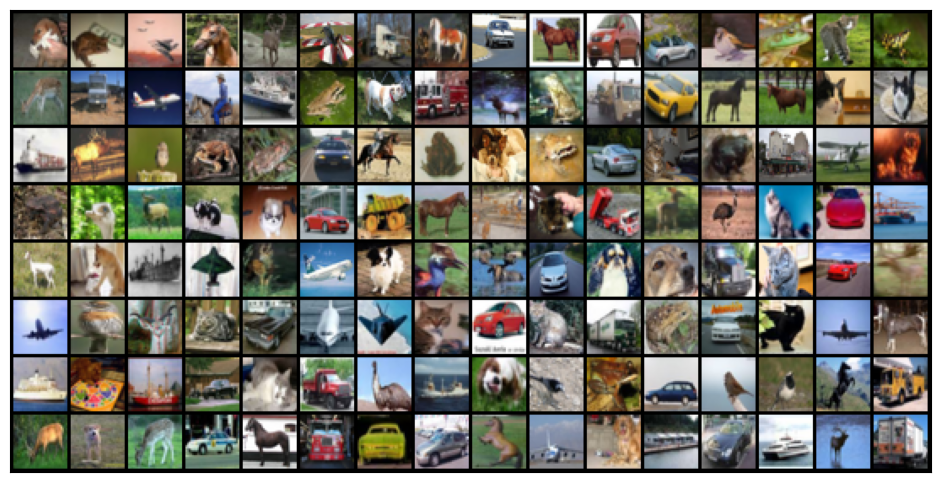

In [28]:
show_batch(train_dl)

## Training 

In [29]:
model = get_cls_model(config)
model.to(torch.device("cpu"))

ConvolutionalVisionTransformer(
  (stage0): VisionTransformer(
    (patch_embed): ConvEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (conv_proj_q): Sequential(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (rearrage): Rearrange('b c h w -> b (h w) c')
          )
          (conv_proj_k): Sequential(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          

In [30]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    for batch in val_loader:
        images, labels = batch 
        out = model(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc} 
    
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    start = time.time()
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        print(f"Epoch{epoch+1}/{epochs}")
        train_losses = []
        for batch in train_loader:

            images, labels = batch 
            out = model(images)                  # Generate predictions
            loss = F.cross_entropy(out, labels) # Calculate loss
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))        
        history.append(result)
    
    print("End With Time = ", time.time() - start)
    return history

In [32]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [33]:
total_params = sum(p.numel() for p in model.parameters())
total_params

19689480

In [34]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch1/10
Epoch [0], train_loss: 1.6958, val_loss: 1.4269, val_acc: 0.4648
Epoch2/10
Epoch [1], train_loss: 1.3566, val_loss: 1.2685, val_acc: 0.5273
Epoch3/10
Epoch [2], train_loss: 1.2043, val_loss: 1.1400, val_acc: 0.5977
Epoch4/10
Epoch [3], train_loss: 1.0940, val_loss: 1.1478, val_acc: 0.5664
Epoch5/10
Epoch [4], train_loss: 0.9759, val_loss: 0.9823, val_acc: 0.6289
Epoch6/10
Epoch [5], train_loss: 0.8778, val_loss: 0.9891, val_acc: 0.6523
Epoch7/10
Epoch [6], train_loss: 0.7948, val_loss: 1.0040, val_acc: 0.6875
Epoch8/10
Epoch [7], train_loss: 0.6974, val_loss: 0.9673, val_acc: 0.6719
Epoch9/10
Epoch [8], train_loss: 0.6242, val_loss: 1.0202, val_acc: 0.6367
Epoch10/10
Epoch [9], train_loss: 0.5507, val_loss: 0.9920, val_acc: 0.6680
End With Time =  1874.7789027690887


In [35]:
evaluate(model, val_dl)

{'val_loss': tensor(0.9920), 'val_acc': tensor(0.6680)}

In [36]:
total_params = sum(p.numel() for p in model.parameters())
total_params

19689480

In [37]:
history


[{'val_loss': tensor(1.4269),
  'val_acc': tensor(0.4648),
  'train_loss': 1.6958225965499878},
 {'val_loss': tensor(1.2685),
  'val_acc': tensor(0.5273),
  'train_loss': 1.3565826416015625},
 {'val_loss': tensor(1.1400),
  'val_acc': tensor(0.5977),
  'train_loss': 1.204334020614624},
 {'val_loss': tensor(1.1478),
  'val_acc': tensor(0.5664),
  'train_loss': 1.0939502716064453},
 {'val_loss': tensor(0.9823),
  'val_acc': tensor(0.6289),
  'train_loss': 0.9758759140968323},
 {'val_loss': tensor(0.9891),
  'val_acc': tensor(0.6523),
  'train_loss': 0.8778141140937805},
 {'val_loss': tensor(1.0040),
  'val_acc': tensor(0.6875),
  'train_loss': 0.7948143482208252},
 {'val_loss': tensor(0.9673),
  'val_acc': tensor(0.6719),
  'train_loss': 0.6973569393157959},
 {'val_loss': tensor(1.0202),
  'val_acc': tensor(0.6367),
  'train_loss': 0.6241584420204163},
 {'val_loss': tensor(0.9920),
  'val_acc': tensor(0.6680),
  'train_loss': 0.5507414937019348}]

In [38]:
train_losses = []
val_losses = []
val_accs = []

for entry in history:
    train_losses.append(entry['train_loss'])
    val_losses.append(entry['val_loss'].item())  
    val_accs.append(entry['val_acc'].item())    


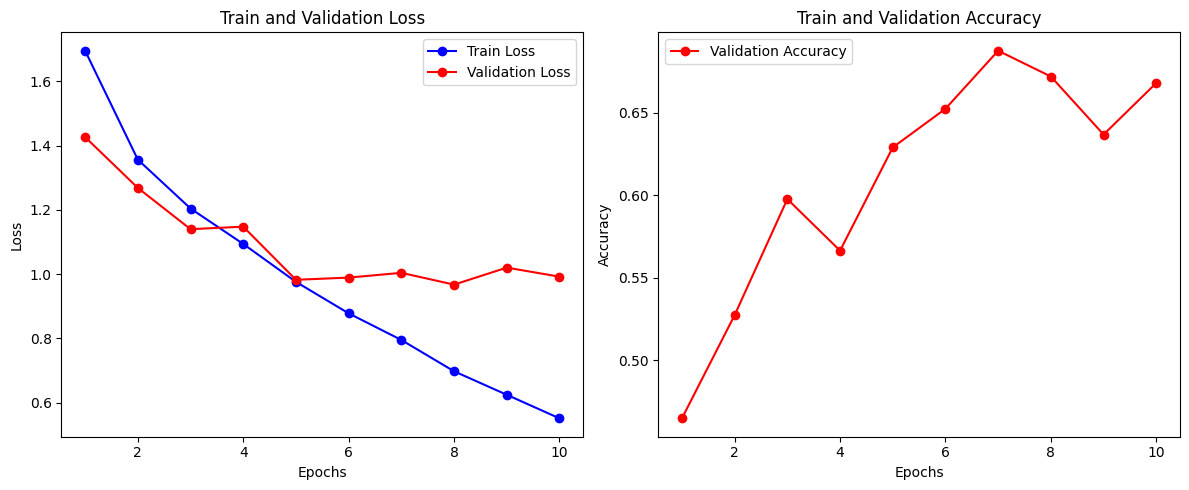

In [39]:
# Loss
plt.figure(figsize=(12, 5))

epochs = range(1, len(train_losses) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()